In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
from PIL import Image
from tqdm import tqdm
import einops

import scipy
import sklearn
import sklearn.model_selection
from sklearn.model_selection import KFold
from sklearn import cross_decomposition

from stMMCR.neural_evaluation.legacy_models import get_model
from stMMCR.training.models import Encoder, Model

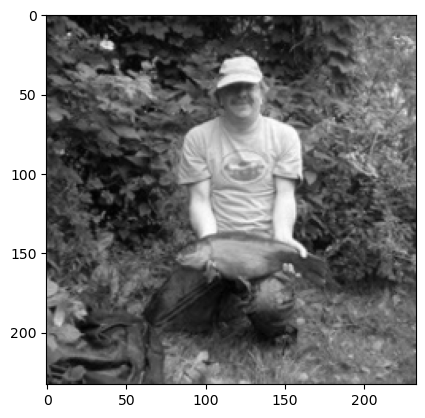

In [2]:
def load_image(idx):
    # image files have format 000xxx.png
    # there are always 6 digits, padded with zeros
    filename = f"./images/images/{idx:06d}.png"
    image = Image.open(filename)
    return np.array(image)

img = load_image(1)

plt.imshow(img, cmap='gray')

In [3]:
class NatImDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        isi_type: str,
        image_directory: str = './images/images/',
        dataset_file_path: str = 'natImRateData.mat',
        split: str = 'train',
        sort_ind: int = 1,
        area_ind: int = 2,
        transform=None,
    ):
        self.isi_type = isi_type
        self.image_directory = image_directory
        self.dataset_file_path = dataset_file_path
        self.sort_ind = sort_ind
        self.area_ind = area_ind
        self.transform = transform

        dataset_file = h5py.File(dataset_file_path, 'r')

        if self.isi_type == 'isi':
            block_ref = dataset_file['natImRateData']['block'][0, 0]
        elif self.isi_type == 'no_isi':
            block_ref = dataset_file['natImRateData']['block'][1, 0]
        else:
            raise ValueError("isi_type must be 'isi' or 'no_isi'")

        self.block = dataset_file[block_ref]
        if split == 'train':
            self.responses = self.block['trainRates'][:]
            self.image_indices = self.block['trainImInd'][:,0]
        elif split == 'test':
            self.responses = self.block['testRates'][:]
            # average over repeats
            self.responses = np.mean(self.responses, axis=0)
            self.image_indices = self.block['testImInd'][:, 0]
        else:
            raise ValueError("split must be 'train' or 'test'")

        # apply appropriate mask to responses
        area_ind_list = np.array(dataset_file['natImRateData']['cellInfo']['areaInd'])
        sort_ind_list = np.array(dataset_file['natImRateData']['cellInfo']['sortInd'])
        self.sort_mask = sort_ind_list <= self.sort_ind
        self.area_mask = area_ind_list == self.area_ind
        cell_mask = self.sort_mask & self.area_mask
        self.cell_mask = cell_mask[0, :]

        self.responses = self.responses[:, self.cell_mask]

    def __len__(self):
        return self.responses.shape[0]

    def __getitem__(self, idx):
        response = self.responses[idx, :]
        image_idx = self.image_indices[idx]
        image = self._load_image(int(image_idx))
        if self.transform:
            image = self.transform(image)
        
        return image, response

    def _load_image(self, idx):
        # image files have format 000xxx.png
        # there are always 6 digits, padded with zeros
        filename = f"{self.image_directory}/{idx:06d}.png"
        image = Image.open(filename)
        return np.array(image)

In [4]:
imsize = 112
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((imsize, imsize)),
        torchvision.transforms.Grayscale(),
        torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset_isi = NatImDataset(
    isi_type='isi',
    image_directory='./images/images/',
    dataset_file_path='./natImRateData.mat',
    split='train',
    sort_ind=1,
    area_ind=2,
    transform=transform,
)

test_dataset_isi = NatImDataset(
    isi_type='isi',
    image_directory='./images/images/',
    dataset_file_path='./natImRateData.mat',
    split='test',
    sort_ind=1,
    area_ind=2,
    transform=transform,
)

train_dataset_no_isi = NatImDataset(
    isi_type='no_isi',
    image_directory='./images/images/',
    dataset_file_path='./natImRateData.mat',
    split='train',
    sort_ind=1,
    area_ind=2,
    transform=transform,
)
test_dataset_no_isi = NatImDataset(
    isi_type='no_isi',
    image_directory='./images/images/',
    dataset_file_path='./natImRateData.mat',
    split='test',
    sort_ind=1,
    area_ind=2,
    transform=transform,
)

train_dataloader_isi = torch.utils.data.DataLoader(train_dataset_isi, batch_size=32, shuffle=False, num_workers=4)
test_dataloader_isi = torch.utils.data.DataLoader(test_dataset_isi, batch_size=32, shuffle=False, num_workers=4)

train_dataloader_no_isi = torch.utils.data.DataLoader(train_dataset_no_isi, batch_size=32, shuffle=False, num_workers=4)
test_dataloader_no_isi = torch.utils.data.DataLoader(test_dataset_no_isi, batch_size=32, shuffle=False, num_workers=4)

In [7]:
def get_responses(model, dataloader, return_layers):
    model_responses = {k: [] for k in return_layers}
    neural_responses = []
    for img, response in tqdm(dataloader):
        img = img.cuda()
        with torch.no_grad():
            out, _ = model(img) 

        for k in return_layers:
            model_responses[k].append(
                einops.rearrange(out[k].cpu().numpy(), 'b c h w -> b (c h w)')
            )
        
        neural_responses.append(response.numpy())

    model_responses = {k: np.concatenate(v, axis=0) for k, v in model_responses.items()}
    neural_responses = np.concatenate(neural_responses, axis=0)

    return model_responses, neural_responses

In [5]:
model_sup = torchvision.models.alexnet(pretrained=True)
model_rand = torchvision.models.alexnet(pretrained=False)
model_rob, _ = get_model('alexnet_rob')

return_layers = [
    'features.2', # max pool 1
    'features.5', # max pool 2
    'features.7', # relu 3
    'features.9', # relu 4
    'features.12', # max pool 4
]
model_sup = MidGetter(model_sup.cuda().eval(), return_layers={layer: layer for layer in return_layers}, keep_output=False)
model_rand = MidGetter(model_rand.cuda().eval(), return_layers={layer: layer for layer in return_layers}, keep_output=False)
model_rob = MidGetter(model_rob.cuda().eval(), return_layers={layer: layer for layer in return_layers}, keep_output=False)

/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /dev/shm/.cache-tyerxa/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233M/233M [00:0

In [8]:
# train responses
X_train_sup_isi, Y_train_isi = get_responses(model_sup, train_dataloader_isi, return_layers)
X_train_sup_no_isi, Y_train_no_isi = get_responses(model_sup, train_dataloader_no_isi, return_layers)

X_train_rob_isi, Y_train_isi = get_responses(model_rob, train_dataloader_isi, return_layers)
X_train_rob_no_isi, Y_train_no_isi = get_responses(model_rob, train_dataloader_no_isi, return_layers)

X_train_rand_isi, Y_train_isi = get_responses(model_rand, train_dataloader_isi, return_layers)
X_train_rand_no_isi, Y_train_no_isi = get_responses(model_rand, train_dataloader_no_isi, return_layers)

# test_responses
X_test_sup_isi, Y_test_isi = get_responses(model_sup, test_dataloader_isi, return_layers)
X_test_sup_no_isi, Y_test_no_isi = get_responses(model_sup, test_dataloader_no_isi, return_layers)

X_test_rob_isi, Y_test_isi = get_responses(model_rob, test_dataloader_isi, return_layers)
X_test_rob_no_isi, Y_test_no_isi = get_responses(model_rob, test_dataloader_no_isi, return_layers)  

X_test_rand_isi, Y_test_isi = get_responses(model_rand, test_dataloader_isi, return_layers)
X_test_rand_no_isi, Y_test_no_isi = get_responses(model_rand, test_dataloader_no_isi, return_layers)

  0%|                                                                                                                                                                                      | 0/247 [00:00<?, ?it/s]/mnt/home/tyerxa/miniconda3/envs/rotating-ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/mnt/home/tyerxa/miniconda3/envs/rotati

In [10]:
def get_predictors(X_train, Y_train):
    predictors = {}
    for k in X_train.keys():
        pls = cross_decomposition.PLSRegression(n_components=25, scale=False)
        pls.fit(X_train[k], Y_train)
        predictors[k] = pls
    return predictors 

def get_predictions(predictors, X_test):
    predictions = {}
    for k in X_test.keys():
        predictions[k] = predictors[k].predict(X_test[k])
    return predictions

predictors_sup_isi = get_predictors(X_train_sup_isi, Y_train_isi)
print("Predictors for supervised model with ISI data created.")
predictors_sup_no_isi = get_predictors(X_train_sup_no_isi, Y_train_no_isi)
print("Predictors for supervised model with no ISI data created.")
predictors_rob_isi = get_predictors(X_train_rob_isi, Y_train_isi)
print("Predictors for robust model with ISI data created.")
predictors_rob_no_isi = get_predictors(X_train_rob_no_isi, Y_train_no_isi)
print("Predictors for robust model with no ISI data created.")
predictors_rand_isi = get_predictors(X_train_rand_isi, Y_train_isi)
print("Predictors for random model with ISI data created.")
predictors_rand_no_isi = get_predictors(X_train_rand_no_isi, Y_train_no_isi)
print("Predictors for random model with no ISI data created.")

Predictors for supervised model with ISI data created.
Predictors for supervised model with no ISI data created.
Predictors for robust model with ISI data created.
Predictors for robust model with no ISI data created.
Predictors for random model with ISI data created.
Predictors for random model with no ISI data created.


In [12]:
def get_scores(predictors, X_test, Y_test, split_half_corrs=None):
    scores = {}
    for k in X_test.keys():
        predictions = predictors[k].predict(X_test[k])
        test_corrs = [
            scipy.stats.pearsonr(predictions[:, i], Y_test[:, i])[0] for i in range(Y_test.shape[1])
        ]
        test_corrs = np.array(test_corrs)

        if split_half_corrs is not None:
            ceils = (2 * split_half_corrs) / (1 + split_half_corrs)
            fevs = (test_corrs / ceils) ** 2
            scores[k] = np.nanmedian(fevs)
        else:
            scores[k] = np.nanmedian(test_corrs)

    return scores

In [13]:
split_half_corrs_isi = np.load('isi_mean_split_half_corrs.npy')
split_half_corrs_no_isi = np.load('noisi_mean_split_half_corrs.npy')

corrs_sup_isi = get_scores(predictors_sup_isi, X_test_sup_isi, Y_test_isi, split_half_corrs=None)
corrs_sup_no_isi = get_scores(predictors_sup_no_isi, X_test_sup_no_isi, Y_test_no_isi, split_half_corrs=None)
fevs_sup_isi = get_scores(predictors_sup_isi, X_test_sup_isi, Y_test_isi, split_half_corrs=split_half_corrs_isi)
fevs_sup_no_isi = get_scores(predictors_sup_no_isi, X_test_sup_no_isi, Y_test_no_isi, split_half_corrs=split_half_corrs_no_isi)

corrs_rob_isi = get_scores(predictors_rob_isi, X_test_rob_isi, Y_test_isi, split_half_corrs=None)
corrs_rob_no_isi = get_scores(predictors_rob_no_isi, X_test_rob_no_isi, Y_test_no_isi, split_half_corrs=None)
fevs_rob_isi = get_scores(predictors_rob_isi, X_test_rob_isi, Y_test_isi, split_half_corrs=split_half_corrs_isi)
fevs_rob_no_isi = get_scores(predictors_rob_no_isi, X_test_rob_no_isi, Y_test_no_isi, split_half_corrs=split_half_corrs_no_isi)

corrs_rand_isi = get_scores(predictors_rand_isi, X_test_rand_isi, Y_test_isi, split_half_corrs=None)
corrs_rand_no_isi = get_scores(predictors_rand_no_isi, X_test_rand_no_isi, Y_test_no_isi, split_half_corrs=None)        
fevs_rand_isi = get_scores(predictors_rand_isi, X_test_rand_isi, Y_test_isi, split_half_corrs=split_half_corrs_isi)
fevs_rand_no_isi = get_scores(predictors_rand_no_isi, X_test_rand_no_isi, Y_test_no_isi, split_half_corrs=split_half_corrs_no_isi)

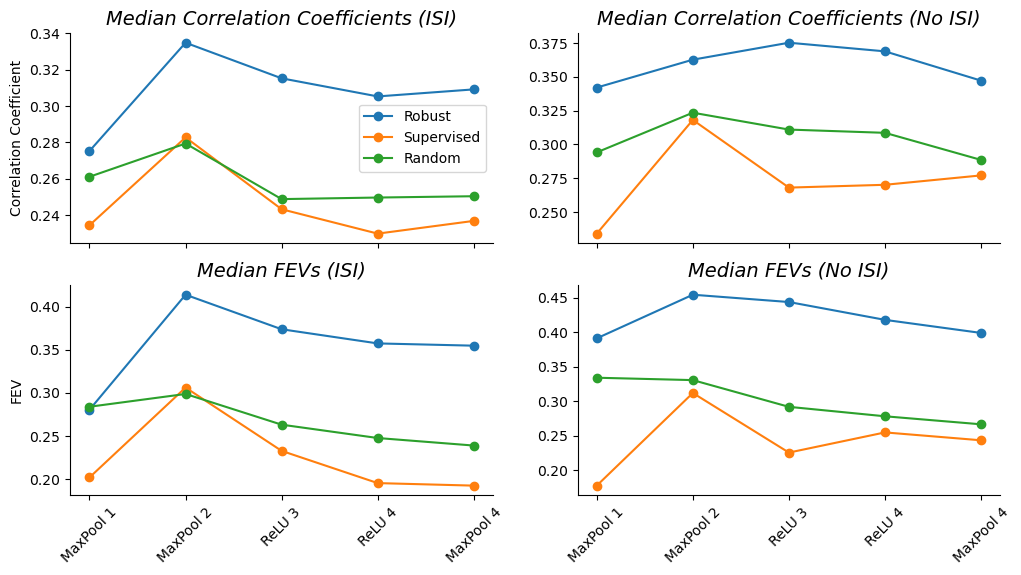

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].plot(corrs_rob_isi.values(), label='Robust', marker='o')
axs[0, 0].plot(corrs_sup_isi.values(), label='Supervised', marker='o')
axs[0, 0].plot(corrs_rand_isi.values(), label='Random', marker='o')

axs[1, 0].plot(fevs_rob_isi.values(), label='Robust', marker='o')
axs[1, 0].plot(fevs_sup_isi.values(), label='Supervised', marker='o')
axs[1, 0].plot(fevs_rand_isi.values(), label='Random', marker='o')

axs[0, 1].plot(corrs_rob_no_isi.values(), label='Robust', marker='o')
axs[0, 1].plot(corrs_sup_no_isi.values(), label='Supervised', marker='o')
axs[0, 1].plot(corrs_rand_no_isi.values(), label='Random', marker='o')

axs[1, 1].plot(fevs_rob_no_isi.values(), label='Robust', marker='o')
axs[1, 1].plot(fevs_sup_no_isi.values(), label='Supervised', marker='o')
axs[1, 1].plot(fevs_rand_no_isi.values(), label='Random', marker='o')

xtick_labels = [
    'MaxPool 1',
    'MaxPool 2',
    'ReLU 3',
    'ReLU 4',
    'MaxPool 4',
]
for ax in axs.flat:
    # turn off top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(len(corrs_sup_isi)))


# turn off xtick labels for top row
axs[0, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[1, 0].set_xticklabels(xtick_labels, rotation=45)
axs[1, 1].set_xticklabels(xtick_labels, rotation=45)

axs[0, 0].set_title('Median Correlation Coefficients (ISI)', fontstyle='italic', fontsize=14)
axs[0, 1].set_title('Median Correlation Coefficients (No ISI)', fontstyle='italic', fontsize=14)
axs[1, 0].set_title('Median FEVs (ISI)', fontstyle='italic', fontsize=14)
axs[1, 1].set_title('Median FEVs (No ISI)', fontstyle='italic', fontsize=14)
axs[0, 0].set_ylabel('Correlation Coefficient')
axs[1, 0].set_ylabel('FEV')
axs[0, 0].legend()

